# F20DL Lab 8

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd
import math
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
# Load the dataset into numpy arrays
images = np.load("./datasets/smiley_X.npy")
labels = np.load("./datasets/smiley_Y.npy")

In [3]:
# Flatten image data and convert values to int
X = np.asarray([x.flatten() for x in images]).astype(int)
y = labels.astype(int)

In [4]:
# data is a list of all images. Images are represented as a flattened row of pixel values.
# To get pixel (r, c) of image i, use X[i-1][9*(r-1) + (c-1)] 
# Or use images[i][r-1][c-1][0]

# X[0] returns a row of pixel values representing the 1st image.
# X[0][24] and images[0][2][6][0] return the value of the pixel in the 3rd row and 7th column of the 1st image 
# (r=3, c=7).
# y[0] returns the label for the 1st image.
images[0][0][0][0]

0.0

In [5]:
# Shows smiley as an image. 'smiley' should be an element in 'images'
def show_smiley(smiley):
    plt.figure(figsize=(2,2))
    plt.imshow(smiley, cmap="Greys")

In [6]:
# Shifts a percentage of instances from the training set to the test set and returns the new training and test sets
def shift_instances(d_train, d_test, t_train, t_test, percent):    
    shift_count = math.ceil(percent * d_train.shape[0])    # No. of instances to shift

    # Shift first x% of samples to test set
    new_d_train = d_train[shift_count:]
    new_d_test = np.concatenate((d_test, d_train[:shift_count]))
    new_t_train = t_train[shift_count:]
    new_t_test = np.concatenate((t_test, t_train[:shift_count]))
    return (new_d_train, new_d_test, new_t_train, new_t_test)

In [7]:
# Displays confusion matrix and prints common evaluation metrics
def show_metrics(clf, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    
    acc = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f_measure = (2 * recall * precision) / (recall + precision)
    
    text = f'''
    Metrics for Class 1:
    Accuracy =   {acc:.3f}
    TP rate =    {tpr:.3f}
    FP rate =    {fpr:.3f}
    Precision =  {precision:.3f}
    Recall =     {recall:.3f}
    F measure =  {f_measure:.3f}
    '''
    
    fig, axes = plt.subplots(figsize=(4,4))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot(ax=axes)
    plt.show()
    
    print(text)

## Decision Trees

### Tree 0

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1) # 70% training and 30% test
print("Training samples: %i, Testing samples: %i" % (X_train.shape[0], X_test.shape[0]))

Training samples: 14, Testing samples: 130


In [9]:
# Create Decision Tree classifer object
classifier = DecisionTreeClassifier()

# Train Decision Tree Classifer
classifier = classifier.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = classifier.predict(X_train)

In [10]:
accuracy_score(y_train, y_pred)

1.0

In [11]:
cross_val_score(classifier, X_train, y_train, cv=6)

array([1. , 1. , 0.5, 1. , 1. , 0.5])

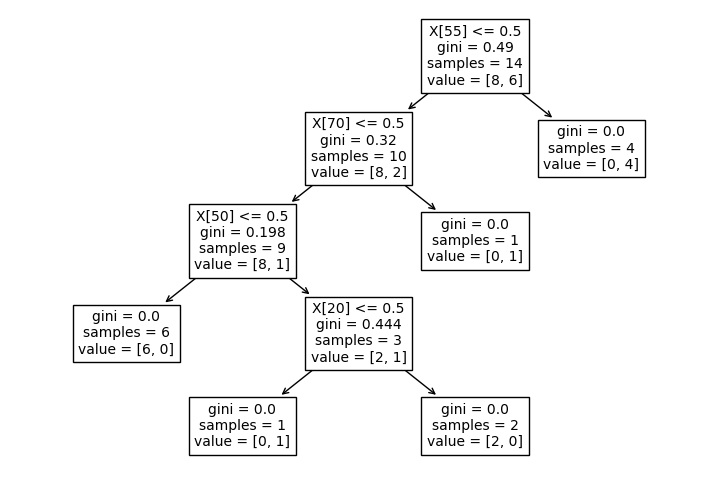

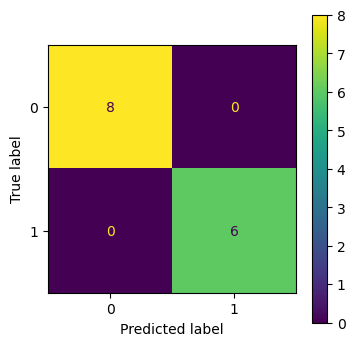


    Metrics for Class 1:
    Accuracy =   1.000
    TP rate =    1.000
    FP rate =    0.000
    Precision =  1.000
    Recall =     1.000
    F measure =  1.000
    


In [12]:
plt.figure(figsize=(9,6))
plot_tree(classifier, fontsize=10)
plt.show()

show_metrics(classifier, y_train, y_pred)

## Hyperparameter Regularisation

We want to create a number of trees using different parameters to evaluate each parameters effect on the resulting model. This is to increase or reduce overfitting where necessary to give a model that extends well to testing data. We'll compare the resulting scores of each model and evaluate the trees themselves.

In [13]:
def hyperparameter_regularisation(X_train, X_test, y_train, y_test, max_depth = None, min_samples_leaf = 1):
    tree = DecisionTreeClassifier(max_depth = max_depth, min_samples_leaf = min_samples_leaf, random_state = 1)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)

    score = accuracy_score(y_test, y_pred)
    
    return tree, score

## Test 1

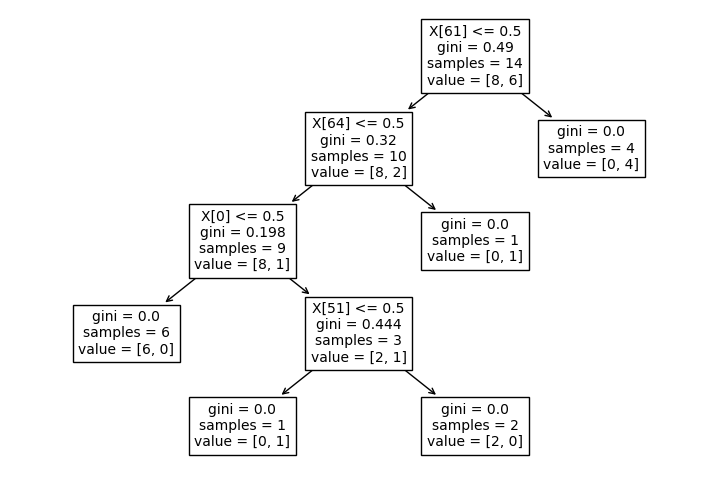

Score: 0.69


In [14]:
tree_1, score_1 = hyperparameter_regularisation(X_train, X_test, y_train, y_test)

plt.figure(figsize=(9,6))
plot_tree(tree_1, fontsize=10)
plt.show()
print("Score: {:.2f}".format(score_1))

This tree has a score of 69%. Due to the high dispersal of the samples it appears that the tree may be slightly overfitting the training data. One way of reducing the overfitting is to set a limit on the tree depth. This is done with the `max_depth` parameter in Test 2.

## Test 2

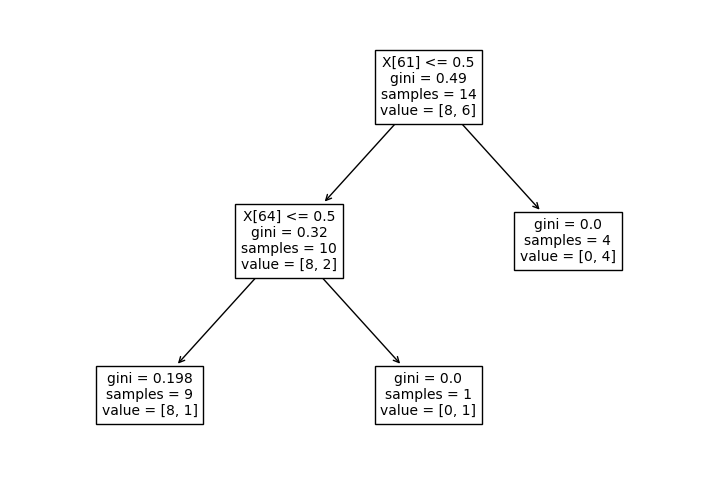

Score: 0.73


In [15]:
tree_2, score_2 = hyperparameter_regularisation(X_train, X_test, y_train, y_test, max_depth = 2)

plt.figure(figsize=(9,6))
plot_tree(tree_2, fontsize=10)
plt.show()
print("Score: {:.2f}".format(score_2))

This tree was produced with the maximum depth set to 2. Any model produced, therefore, cannot exceed two levels beyond the root node. This constraint slightly improves our score compared to the previous model by reducing the overfitting, as demonstrated by the higher value counts in each leaf node.

## Test 3

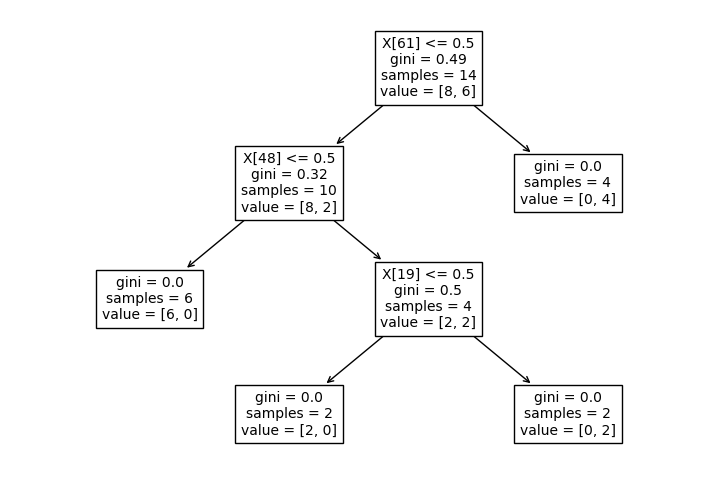

Score: 0.68


In [16]:
tree_3, score_3 = hyperparameter_regularisation(X_train, X_test, y_train, y_test, min_samples_leaf = 2)

plt.figure(figsize=(9,6))
plot_tree(tree_3, fontsize=10)
plt.show()
print("Score: {:.2f}".format(score_3))

Another way to recude overfitting is to set the minimum number of samples that each leaf node can capture. As demonstrated in the above chart this does reduce the dispersal of the values when compared to Test 1.

However, it does reduce the accuracy of the model and thus results in a lower score.

### Conclusion

It appears that, in this case, reducing the depth of the decision tree is the best way to reduce the overfitting and increase the score. The simpler tree is a better model of the data found in the test set.

## Tuned Decision Trees

In [17]:
# Tuned hyperparameters
t_max_depth = 2

### Tree 1

In [18]:
# Create Decision Tree classifer object
classifier1 = DecisionTreeClassifier(max_depth=t_max_depth)

# Train Decision Tree Classifer
classifier1 = classifier1.fit(X_train,y_train)

#Predict the response for test dataset
y1_pred = classifier1.predict(X_test)

In [19]:
accuracy_score(y_test, y1_pred)

0.7307692307692307

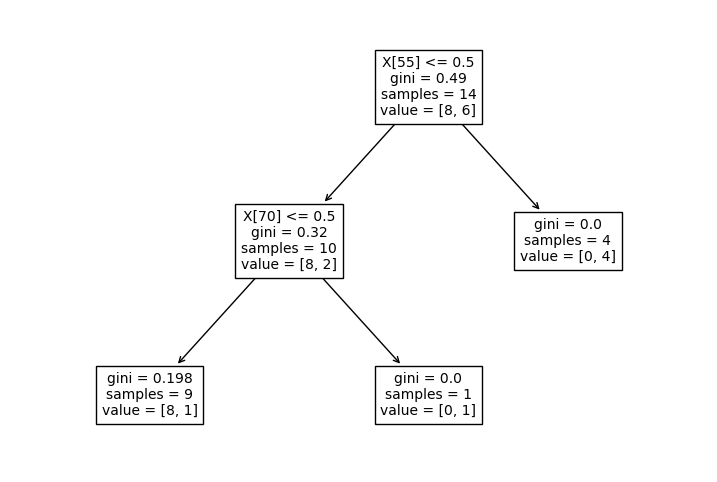

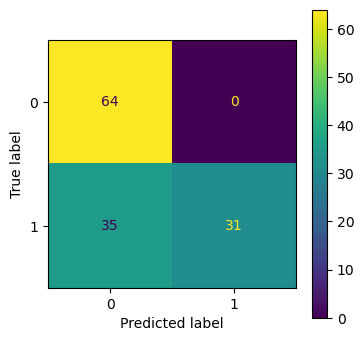


    Metrics for Class 1:
    Accuracy =   0.731
    TP rate =    0.470
    FP rate =    0.000
    Precision =  1.000
    Recall =     0.470
    F measure =  0.639
    


In [20]:
plt.figure(figsize=(9,6))
plot_tree(classifier1, fontsize=10)
plt.show()

show_metrics(classifier1, y_test, y1_pred)

### Tree 2

In [21]:
# Shift 30% of original training data to test set
X2_train, X2_test, y2_train, y2_test = shift_instances(X_train, X_test, y_train, y_test, 0.3)
print("Training samples: %i, Testing samples: %i" % (X2_train.shape[0], X2_test.shape[0]))

Training samples: 9, Testing samples: 135


In [22]:
# Create Decision Tree classifer object
classifier2 = DecisionTreeClassifier(max_depth=t_max_depth)

# Train Decision Tree Classifer
classifier2 = classifier2.fit(X2_train,y2_train)

#Predict the response for test dataset
y2_pred = classifier2.predict(X2_test)

In [23]:
accuracy_score(y2_test, y2_pred)

0.8222222222222222

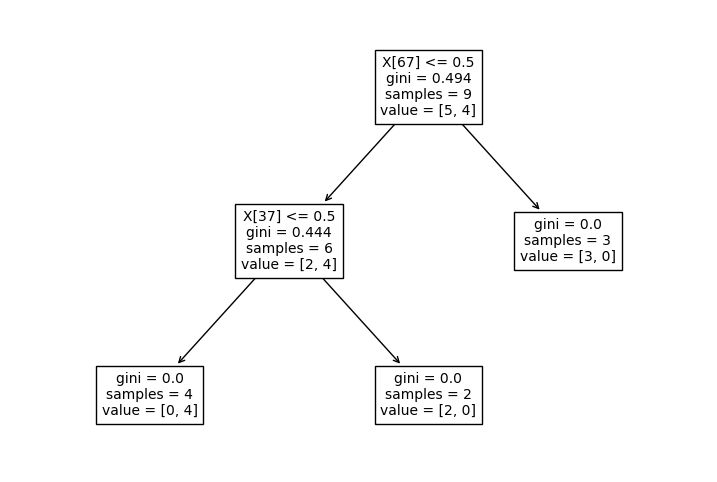

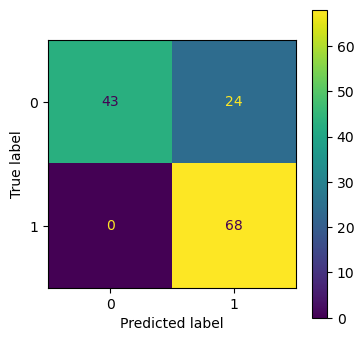


    Metrics for Class 1:
    Accuracy =   0.822
    TP rate =    1.000
    FP rate =    0.358
    Precision =  0.739
    Recall =     1.000
    F measure =  0.850
    


In [24]:
plt.figure(figsize=(9,6))
plot_tree(classifier2, fontsize=10)
plt.show()

show_metrics(classifier2, y2_test, y2_pred)

### Tree 3

In [25]:
# Shift 60% of original training data to test set
X3_train, X3_test, y3_train, y3_test = shift_instances(X_train, X_test, y_train, y_test, 0.6)
print("Training samples: %i, Testing samples: %i" % (X3_train.shape[0], X3_test.shape[0]))

Training samples: 5, Testing samples: 139


In [26]:
# Create Decision Tree classifer object
classifier3 = DecisionTreeClassifier(max_depth=t_max_depth)

# Train Decision Tree Classifer
classifier3 = classifier3.fit(X3_train,y3_train)

#Predict the response for test dataset
y3_pred = classifier3.predict(X3_test)

In [27]:
accuracy_score(y3_test, y3_pred)

0.6546762589928058

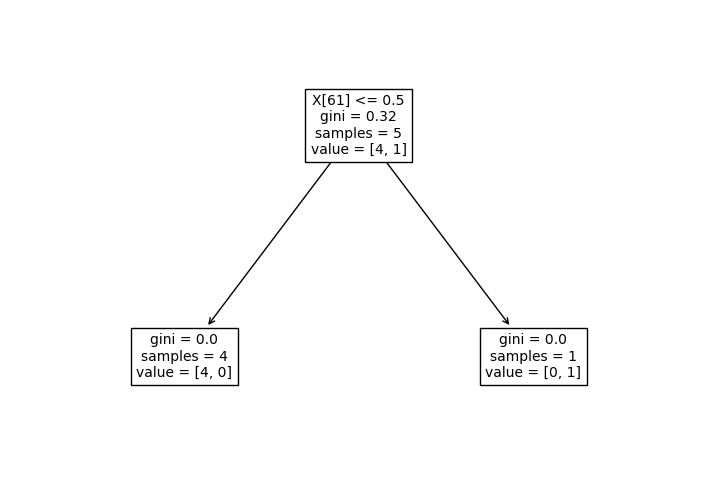

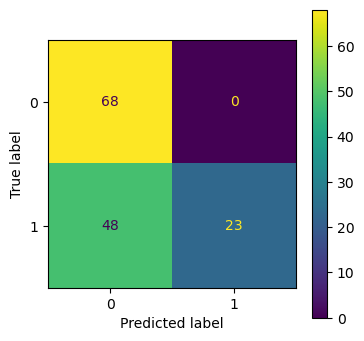


    Metrics for Class 1:
    Accuracy =   0.655
    TP rate =    0.324
    FP rate =    0.000
    Precision =  1.000
    Recall =     0.324
    F measure =  0.489
    


In [28]:
plt.figure(figsize=(9,6))
plot_tree(classifier3, fontsize=10)
plt.show()

show_metrics(classifier3, y3_test, y3_pred)

## Random Forest Trees

### Tree 0

In [29]:
from sklearn.ensemble import RandomForestClassifier

RFClassifier = RandomForestClassifier()

RFClassifier = RFClassifier.fit(X_train,y_train)

RFy_pred = RFClassifier.predict(X_train)

In [30]:
accuracy_score(y_train, RFy_pred)

1.0

In [31]:
cross_val_score(RFClassifier, X_train, y_train, cv=6)

array([1. , 1. , 0.5, 1. , 0.5, 1. ])

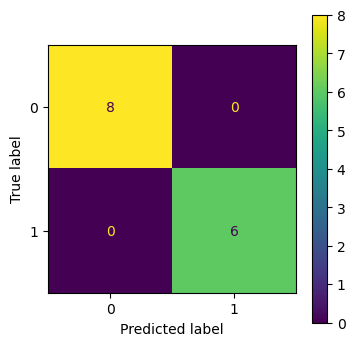


    Metrics for Class 1:
    Accuracy =   1.000
    TP rate =    1.000
    FP rate =    0.000
    Precision =  1.000
    Recall =     1.000
    F measure =  1.000
    


In [32]:
show_metrics(RFClassifier, y_train, RFy_pred)

### Tree 1

In [33]:
RFClassifier1 = RandomForestClassifier()

RFClassifier1 = RFClassifier1.fit(X_train,y_train)

RFy1_pred = RFClassifier1.predict(X_test)

In [34]:
accuracy_score(y_test, RFy1_pred)

0.9769230769230769

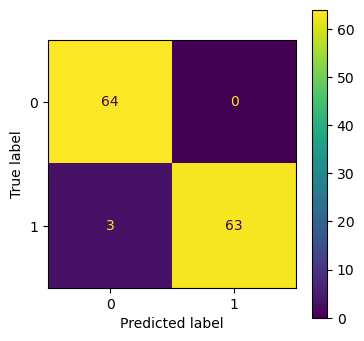


    Metrics for Class 1:
    Accuracy =   0.977
    TP rate =    0.955
    FP rate =    0.000
    Precision =  1.000
    Recall =     0.955
    F measure =  0.977
    


In [35]:
show_metrics(RFClassifier1, y_test, RFy1_pred)

### Tree 2

In [36]:
RFClassifier2 = RandomForestClassifier()

RFClassifier2 = RFClassifier2.fit(X2_train,y2_train)

RFy2_pred = RFClassifier2.predict(X2_test)

In [37]:
accuracy_score(y2_test, RFy2_pred)

0.8962962962962963

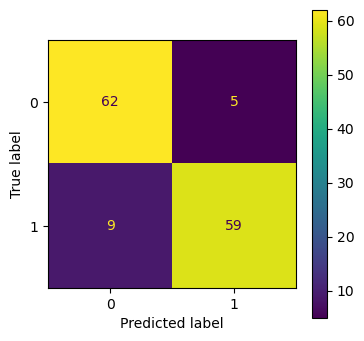


    Metrics for Class 1:
    Accuracy =   0.896
    TP rate =    0.868
    FP rate =    0.075
    Precision =  0.922
    Recall =     0.868
    F measure =  0.894
    


In [38]:
show_metrics(RFClassifier2, y2_test, RFy2_pred)

### Tree 3

In [39]:
RFClassifier3 = RandomForestClassifier()

RFClassifier3 = RFClassifier3.fit(X3_train,y3_train)

RFy3_pred = RFClassifier3.predict(X3_test)

In [40]:
accuracy_score(y3_test, RFy3_pred)

0.5827338129496403

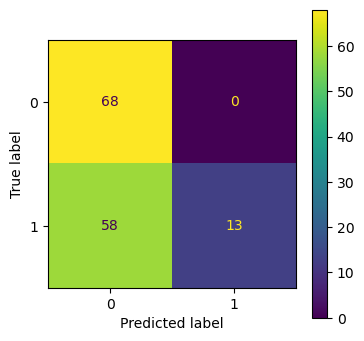


    Metrics for Class 1:
    Accuracy =   0.583
    TP rate =    0.183
    FP rate =    0.000
    Precision =  1.000
    Recall =     0.183
    F measure =  0.310
    


In [41]:
show_metrics(RFClassifier3, y3_test, RFy3_pred)